In [1]:
# ================================
# Step 1: Imports
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

# ================================
# Step 2: Load and Clean Data
# ================================
df = pd.read_csv('BetelPrice.csv')

# Convert Date
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Sort by Date
df = df.sort_values('Date').reset_index(drop=True)

# Safe removal of garbage columns
garbage_columns = ['Unnamed: 6', ' ']
df = df.drop(columns=[col for col in garbage_columns if col in df.columns])

# Clean Price
df = df.dropna(subset=['Price'])
df = df[df['Price'] > 0].reset_index(drop=True)

print("Final rows:", len(df))
print("Price range:", df['Price'].min(), "to", df['Price'].max())

Final rows: 9429
Price range: 20 to 30000


In [2]:
# ================================
# Step 3: Feature Engineering - Add Date/Time Features
# ================================
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfMonth'] = df['Date'].dt.day
df['DayOfYear'] = df['Date'].dt.dayofyear
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(float)
df['IsWeekend'] = (df['Date'].dt.weekday >= 5).astype(float)

# Cyclical encoding for Month and DayOfYear (helps neural nets understand cycles)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)

# Optional: Drop original Month/DayOfYear if you want to reduce features
# df = df.drop(columns=['Month', 'DayOfYear'])

In [3]:
# ================================
# Step 4: One-Hot Encode Categoricals
# ================================
categorical_cols = ['District', 'Market Type', 'Commercial Type', 'Quality Grade']

df_encoded = pd.get_dummies(df, columns=categorical_cols, dtype=float, drop_first=True)

# Keep Date for later plotting
dates = df_encoded['Date'].values

# Define features: Price + all encoded + all date features
encoded_cols = [col for col in df_encoded.columns if col not in ['Date', 'Price']]
features = ['Price'] + encoded_cols

print("Total features:", len(features))
print("Example features:", features[:10], "...")

data = df_encoded[features].values.astype(np.float32)

Total features: 17
Example features: ['Price', 'Year', 'Month', 'DayOfMonth', 'DayOfYear', 'WeekOfYear', 'IsWeekend', 'Month_sin', 'Month_cos', 'DayOfYear_sin'] ...


In [4]:
# ================================
# Step 5: Log Transform + Scale Price
# ================================
# Log transform Price
data_log = data.copy()
data_log[:, 0] = np.log(data[:, 0])

# Scale only the log-price column
scaler_price = MinMaxScaler(feature_range=(0, 1))
data_scaled = data_log.copy()
data_scaled[:, 0] = scaler_price.fit_transform(data_log[:, [0]]).flatten()

print("Log+Scaled Price min/max:", data_scaled[:, 0].min(), data_scaled[:, 0].max())

# Inverse function
def inverse_price(pred_scaled):
    if pred_scaled.ndim == 1:
        pred_scaled = pred_scaled.reshape(-1, 1)
    pred_log = scaler_price.inverse_transform(pred_scaled)
    return np.exp(pred_log).flatten()

Log+Scaled Price min/max: 0.0 1.0


In [5]:
# ================================
# Step 6: Create Sequences
# ================================
def create_multivariate_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps, 0])  # Next log-scaled price
    return np.array(X), np.array(y)

time_steps = 60  # You can try 90 or 120 later
X, y = create_multivariate_sequences(data_scaled, time_steps)

print("X shape:", X.shape)  # e.g., (9369, 60, n_features)
print("y shape:", y.shape)

X shape: (9369, 60, 17)
y shape: (9369,)


In [6]:
# ================================
# Step 7: Train-Test Split
# ================================
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

test_dates = dates[split_idx + time_steps:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 7495
Testing samples: 1874


In [7]:
# ================================
# Step 8: Build Improved LSTM Model
# ================================
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, n_features)))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50))
model.add(Dropout(0.3))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0),
    loss='mse'
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        47,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,401 (626.57 KB)

 Trainable params: 160,401 (626.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0568 - val_loss: 0.0302
Epoch 2/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0309 - val_loss: 0.0335
Epoch 3/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0293 - val_loss: 0.0350
Epoch 4/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0283 - val_loss: 0.0347
Epoch 5/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0269 - val_loss: 0.0350
Epoch 6/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0266 - val_loss: 0.0404
Epoch 7/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0270 - val_loss: 0.0335
Epoch 8/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0262 - val_loss: 0.0353
Epoch 9/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0272 - val_loss: 0.0356
Epoch 10/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0259 - val_loss: 0.0389
Epoch 11/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0267 - val_loss: 0.0336
Epoch 12/200
211/211 ━━━━━━━━━

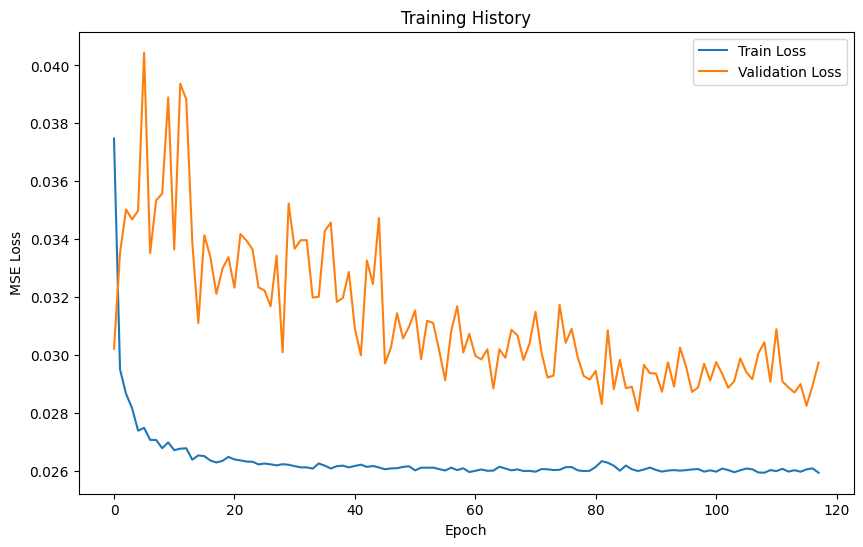

In [8]:
# ================================
# Step 9: Train with Early Stopping
# ================================
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [9]:
# ================================
# Step 10: Evaluate
# ================================
y_pred_scaled = model.predict(X_test)
y_pred = inverse_price(y_pred_scaled)
y_true = inverse_price(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"\n=== Test Results ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

=== Test Results ===
RMSE: 6153.20
MAE:  4560.00
MAPE: 98.89%


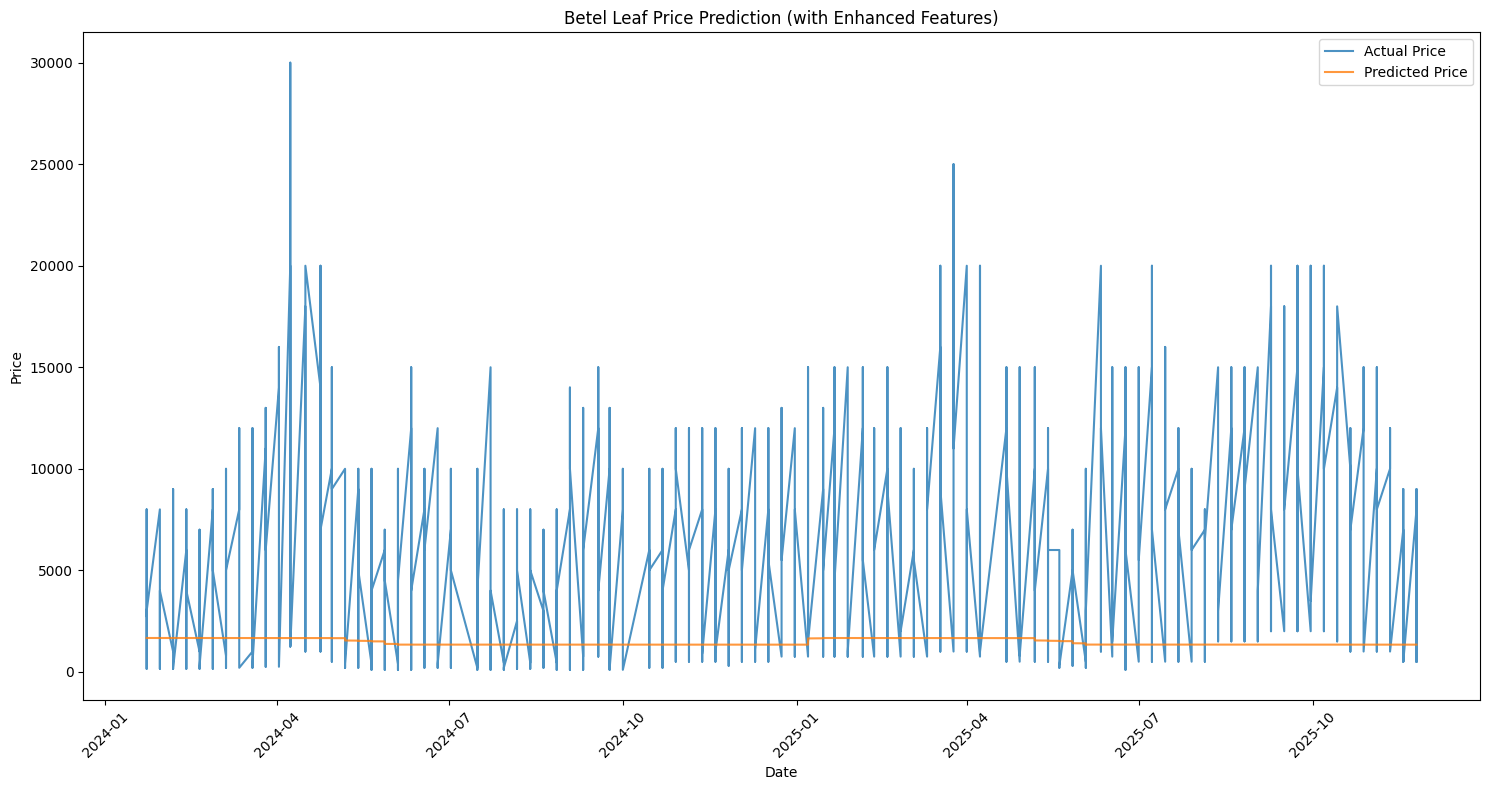

In [10]:
# ================================
# Step 11: Plot Predictions
# ================================
plt.figure(figsize=(15, 8))
plt.plot(test_dates, y_true, label='Actual Price', alpha=0.8)
plt.plot(test_dates, y_pred, label='Predicted Price', alpha=0.8)
plt.title('Betel Leaf Price Prediction (with Enhanced Features)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# ================================
# Step 12: Save Model & Scaler
# ================================
model.save('betel_price_lstm_enhanced.h5')
joblib.dump(scaler_price, 'betel_price_log_scaler_enhanced.pkl')
print("Model and scaler saved!")

Model and scaler saved!
